In [90]:
import pandas as pd
import numpy as np
import spacy
import nltk
import statistics
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

ps = PorterStemmer()
tqdm.pandas()

#### Partisanship chassification using phrases

In [91]:
phrases = {}
for i in tqdm(range(43, 114)):
    file = str(i)
    if i < 100:
        file = '0{}'.format(i)

    # read phrases
    partisan_phrases = pd.read_table("../../phrase_partisanship/partisan_phrases_{}.txt".format(file), sep = "|")
    
    for index, row in partisan_phrases.iterrows():
        if row['phrase'] not in phrases:
            phrases[row['phrase']] = {file: row['partisanship']}
        else:
            phrases[row['phrase']][file] = row['partisanship']

100%|██████████| 71/71 [00:09<00:00,  7.48it/s]


In [92]:
len(phrases)

33210

In [93]:
phrases

{'congression printer': {'043': -182.43155294903198, '044': -22.8408442845079},
 'also petit': {'043': -129.64752875791402,
  '044': 20.0705724538735,
  '045': 13.3642370117232,
  '047': -0.702707961357008,
  '048': 2.60573190021443,
  '049': 3.2140005801750497,
  '050': 5.7860725545496,
  '052': -71.42327842700591,
  '053': 1.64337078058129,
  '055': 8.93992740431594,
  '056': -3.8188594961150004,
  '057': 0.36916279836351795,
  '058': -15.3275995607897,
  '059': -14.424971350018401,
  '060': -117.662479582972,
  '062': -19.0301283404888,
  '063': -6.4805960828218305,
  '064': 4.21089011436535,
  '066': -26.309873659426998,
  '078': -4.06241955138586},
 'speci payment': {'043': 89.6626923079307,
  '044': -20.7296469764678,
  '045': 0.125334342373619,
  '052': 6.1213196786585},
 'increas salari': {'043': -78.0598839905025,
  '044': -2.87783572528955,
  '046': -0.129404997227997,
  '048': -4.904996719637941,
  '049': -51.6201031656094,
  '050': -10.792444456175499,
  '051': -2.014229511

In [95]:
speeches = pd.read_pickle("../dataset.pkl")

answers = speeches['answer']
party = speeches['party_a'].apply(lambda x: 1 if x == 'R' else 0)
year = speeches['year']

speeches = pd.DataFrame({'answer': answers, 'party': party, 'year': year})
speeches.head(15)

,answer,party,year
1,This resolution authorizes the committees to e...,1,043
3,We have no recommendation of record. When the ...,0,043
4,"Yes, sir, it will be contendoed on the other s...",1,043
5,The language of the act to which this is an am...,1,043
6,Unquestionably it would. Governientscannotbo o...,1,043
9,"When say ""laborers"" I mean men in subordinate ...",1,043
10,That does not touch the question. The law prov...,0,043
11,It is not involved in the bill as it came from...,0,043
13,"I say no, decidedly, because the officers of t...",1,043
14,"I might have expected something of that kind, ...",0,043


In [96]:
def stem_answer(x):
    words = word_tokenize(x)
    words = [ps.stem(w.lower()) for w in words]
    stemmed = ' '.join(words)
    return stemmed

In [102]:
stem_answer('increase salary')

'increas salari'

In [98]:
stemmed = speeches['answer'].progress_apply(stem_answer)
speeches['stemmed'] = stemmed

100%|██████████| 43872/43872 [02:17<00:00, 319.49it/s]


In [107]:
speeches.head()

,answer,party,year,stemmed,score
1,This resolution authorizes the committees to e...,1,043,thi resolut author the committe to employ cler...,0.000000
3,We have no recommendation of record. When the ...,0,043,we have no recommend of record . when the eas ...,0.000000
4,"Yes, sir, it will be contendoed on the other s...",1,043,"ye , sir , it will be contendo on the other si...",-0.454704
5,The language of the act to which this is an am...,1,043,the languag of the act to which thi is an amen...,-0.252208
6,Unquestionably it would. Governientscannotbo o...,1,043,unquestion it would . governientscannotbo orga...,-2.536716


In [99]:
def get_score(text, year):
    score = 0
    p = 0
    for k,v in phrases.items():
        if k in text:
            if year in v:
                return v[year]
            else:
                for y,s in v.items():
                    score += s
                    p += 1
            
    if p != 0:
        score = score / p
        
    return score

In [101]:
get_score('increas salari', '045')

-9.448046731308647

In [104]:
score = speeches.progress_apply(lambda x: get_score(x['stemmed'], x['year']), axis=1)
speeches['score'] = score

100%|██████████| 43872/43872 [06:35<00:00, 111.00it/s]


In [108]:
predicted_party =  speeches['score'].progress_apply(lambda x: 1 if x >=0 else 0)

100%|██████████| 43872/43872 [00:00<00:00, 535265.51it/s]


In [109]:
sum(predicted_party != speeches['party']) / len(speeches)

0.4837937636761488

#### Corpus length statistics

In [74]:
speeches['len'] = speeches['answer'].apply(lambda x: len(word_tokenize(x)))

In [75]:
lens = speeches['len']

In [76]:
lens.describe()

count    43839.000000
mean       133.740870
std        191.775405
min          3.000000
25%         38.000000
50%         71.000000
75%        140.000000
max       3384.000000
Name: len, dtype: float64

(array([  34.,  495., 1204., 1746., 1852., 1998., 2109., 1985., 1898.,
        1840., 1736., 1590., 1552., 1361., 1241., 1219., 1120., 1041.,
         951.,  864.,  807.,  715.,  693.,  612.,  620.,  532.,  545.,
         487.,  466.,  420.,  376.,  374.,  350.,  299.,  309.,  243.,
         265.,  283.,  236.,  204.,  214.,  205.,  192.,  158.,  168.,
         164.,  150.,  127.,  168.,  131.,  136.,  127.,  113.,  148.,
         106.,   93.,   91.,  101.,  105.,   75.,   99.,   87.,   96.,
         100.,   67.,   88.,   69.,   66.,   82.,   75.,   63.,   56.,
          58.,   65.,   65.,   79.,   54.,   53.,   44.,   45.,   62.,
          51.,   38.,   48.,   54.,   35.,   42.,   41.,   55.,   39.,
          36.,   42.,   39.,   34.,   39.,   26.,   38.,   29.,   43.,
          42.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145.

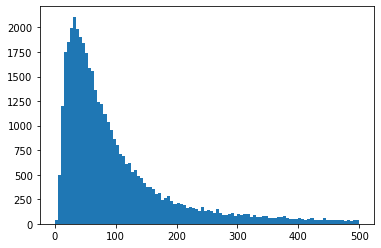

In [80]:
plt.hist(lens, bins=100, range=(0, 500))